In [3]:
import pandas as pd
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score,accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm

In [62]:
# ==== SEED POUR REPRODUCTIBILITÉ ====
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ==== PARAMÈTRES ====
N_CLASSES = 3
MAX_SEQ_LEN = 256
BERT_NAME = 'bert-base-uncased'
BERT_PATH = "../../../../models/bert-base-uncased"
classes = ["handicap", "pet", "child"]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
threshold_train = 0.5

Using device: cuda


In [63]:
# ==== DATASET PERSONNALISÉ ====
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx]) if hasattr(self.texts, 'iloc') else str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }
    
# ==== FONCTION POUR CHARGER ET PRÉPARER LES DONNÉES ====
def get_data(csv_path='dataset_label.csv', train_size=0.85, val_size=0.15):
    """
    Charge et divise les données en ensembles train/val
    """
    df = pd.read_csv(csv_path)
    print(f"Dataset total: {len(df)} exemples")
    
    df = df.sample(frac=1, random_state=seed_value).reset_index(drop=True)
    
    labels = df[classes].values.astype(np.float32)
    sentences = df["review"].fillna("").astype(str)
    
    train_sentences, val_sentences, y_train, y_val = train_test_split(
        sentences, labels, 
        test_size=val_size, 
        random_state=seed_value
    )

    print(f"Train: {len(train_sentences)} | Val: {len(val_sentences)}")
    
    return train_sentences, y_train, val_sentences, y_val

In [64]:
# ==== MODÈLE BERT ====
class BertMultiLabelClassifier(nn.Module):
    def __init__(self, n_classes, dropout=0.3):
        super(BertMultiLabelClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(BERT_PATH)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # Global Average Pooling sur les hidden states
        pooled_output = torch.mean(outputs.last_hidden_state, dim=1)
        
        output = self.dropout(pooled_output)
        output = self.classifier(output)
        output = self.sigmoid(output)
        
        return output

# ==== FONCTION D'ENTRAÎNEMENT ====
def train_epoch(model, data_loader, criterion, optimizer, scheduler, device):
    model.train()
    losses = []
    
    progress_bar = tqdm(data_loader, desc="Training")
    
    for batch in progress_bar:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        loss = criterion(outputs, labels)
        losses.append(loss.item())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'loss': loss.item()})
    
    return np.mean(losses)

# ==== FONCTION D'ÉVALUATION ====
def eval_model(model, data_loader, criterion, device):
    model.eval()
    losses = []
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            
            predictions.extend(outputs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    
    # Calcul des métriques
    auc = roc_auc_score(true_labels, predictions, average='macro')
    
    # Métriques avec threshold 0.5
    pred_binary = (predictions > threshold_train).astype(int)
    accuracy = np.mean(pred_binary == true_labels)
    precision = precision_score(true_labels, pred_binary, average='macro', zero_division=0)
    recall = recall_score(true_labels, pred_binary, average='macro', zero_division=0)
    f1 = f1_score(true_labels, pred_binary, average='macro', zero_division=0)
    
    return {
        'loss': np.mean(losses),
        'auc': auc,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': predictions,
        'true_labels': true_labels
    }

# ==== FINE-TUNING ====
def fine_tune(model, train_loader, val_loader, epochs=3, learning_rate=3e-5):
    criterion = nn.BCELoss()
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )
    
    history = {
        'train_loss': [], 'val_loss': [],
        'train_auc': [], 'val_auc': [],
        'train_accuracy': [], 'val_accuracy': [],
        'train_precision': [], 'val_precision': [],
        'train_recall': [], 'val_recall': [],
        'train_f1': [], 'val_f1': []
    }
    
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        print('-' * 60)
        
        # Training
        train_loss = train_epoch(model, train_loader, criterion, optimizer, scheduler, device)
        
        # Evaluation on train and val
        train_metrics = eval_model(model, train_loader, criterion, device)
        val_metrics = eval_model(model, val_loader, criterion, device)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_metrics['loss'])
        history['train_auc'].append(train_metrics['auc'])
        history['val_auc'].append(val_metrics['auc'])
        history['train_accuracy'].append(train_metrics['accuracy'])
        history['val_accuracy'].append(val_metrics['accuracy'])
        history['train_precision'].append(train_metrics['precision'])
        history['val_precision'].append(val_metrics['precision'])
        history['train_recall'].append(train_metrics['recall'])
        history['val_recall'].append(val_metrics['recall'])
        history['train_f1'].append(train_metrics['f1'])
        history['val_f1'].append(val_metrics['f1'])
        
        print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_metrics["loss"]:.4f}')
        print(f'Train AUC: {train_metrics["auc"]:.4f} | Val AUC: {val_metrics["auc"]:.4f}')
        print(f'Train F1: {train_metrics["f1"]:.4f} | Val F1: {val_metrics["f1"]:.4f}')
        
        # Sauvegarder le modèle basé sur la MEILLEURE VAL LOSS
        if val_metrics['loss'] < best_val_loss:
            best_val_loss = val_metrics['loss']
            torch.save(model.state_dict(), 'best_weights.pth') # Renommez-le pour plus de clarté
            print(f'Model saved! Best Val Loss: {best_val_loss:.4f}')
    
    return history, val_metrics['predictions'], val_metrics['true_labels']

In [65]:
# ==== VISUALISATION DES RÉSULTATS ====
def plot_training_history(history):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss')
    axes[0, 0].plot(history['val_loss'], label='Val Loss')
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # AUC
    axes[0, 1].plot(history['train_auc'], label='Train AUC')
    axes[0, 1].plot(history['val_auc'], label='Val AUC')
    axes[0, 1].set_title('Model AUC')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('AUC')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Accuracy
    axes[1, 0].plot(history['train_accuracy'], label='Train Accuracy')
    axes[1, 0].plot(history['val_accuracy'], label='Val Accuracy')
    axes[1, 0].set_title('Accuracy')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Precision & Recall
    axes[1, 1].plot(history['train_precision'], label='Train Precision')
    axes[1, 1].plot(history['val_precision'], label='Val Precision')
    axes[1, 1].plot(history['train_recall'], label='Train Recall')
    axes[1, 1].plot(history['val_recall'], label='Val Recall')
    axes[1, 1].set_title('Precision & Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    # F1 Score
    axes[0, 2].plot(history['train_f1'], label='Train F1')
    axes[0, 2].plot(history['val_f1'], label='Val F1')
    axes[0, 2].set_title('F1 Score')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('F1 Score')
    axes[0, 2].legend()
    axes[0, 2].grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

BERT MULTI-LABEL CLASSIFICATION - PyTorch

[1/7] Chargement des données...
Dataset total: 2327 exemples
Train: 1977 | Val: 350

[2/7] Initialisation du tokenizer BERT...

[3/7] Création des datasets...

[4/7] Création du modèle BERT...
Nombre de paramètres: 109,484,547

[5/7] Fine-tuning du modèle...

Epoch 1/10
------------------------------------------------------------


Evaluating: 100%|██████████| 11/11 [00:04<00:00,  2.29it/s]


Train Loss: 0.2011 | Val Loss: 0.0601
Train AUC: 0.9965 | Val AUC: 0.9923
Train F1: 0.9864 | Val F1: 0.9735
Model saved! Best Val Loss: 0.0601

Epoch 2/10
------------------------------------------------------------


Evaluating: 100%|██████████| 11/11 [00:04<00:00,  2.26it/s]


Train Loss: 0.0378 | Val Loss: 0.0503
Train AUC: 0.9987 | Val AUC: 0.9936
Train F1: 0.9928 | Val F1: 0.9799
Model saved! Best Val Loss: 0.0503

Epoch 3/10
------------------------------------------------------------


Evaluating: 100%|██████████| 11/11 [00:04<00:00,  2.34it/s]


Train Loss: 0.0222 | Val Loss: 0.0525
Train AUC: 0.9998 | Val AUC: 0.9925
Train F1: 0.9940 | Val F1: 0.9783

Epoch 4/10
------------------------------------------------------------


Evaluating: 100%|██████████| 11/11 [00:04<00:00,  2.30it/s]


Train Loss: 0.0178 | Val Loss: 0.0404
Train AUC: 1.0000 | Val AUC: 0.9938
Train F1: 0.9949 | Val F1: 0.9848
Model saved! Best Val Loss: 0.0404

Epoch 5/10
------------------------------------------------------------


Evaluating: 100%|██████████| 11/11 [00:04<00:00,  2.37it/s]


Train Loss: 0.0112 | Val Loss: 0.0431
Train AUC: 1.0000 | Val AUC: 0.9932
Train F1: 0.9976 | Val F1: 0.9831

Epoch 6/10
------------------------------------------------------------


Evaluating: 100%|██████████| 11/11 [00:04<00:00,  2.49it/s]


Train Loss: 0.0073 | Val Loss: 0.0420
Train AUC: 1.0000 | Val AUC: 0.9935
Train F1: 0.9988 | Val F1: 0.9832

Epoch 7/10
------------------------------------------------------------


Evaluating: 100%|██████████| 11/11 [00:04<00:00,  2.45it/s]


Train Loss: 0.0053 | Val Loss: 0.0310
Train AUC: 1.0000 | Val AUC: 0.9938
Train F1: 0.9988 | Val F1: 0.9880
Model saved! Best Val Loss: 0.0310

Epoch 8/10
------------------------------------------------------------


Evaluating: 100%|██████████| 11/11 [00:04<00:00,  2.26it/s]


Train Loss: 0.0043 | Val Loss: 0.0386
Train AUC: 1.0000 | Val AUC: 0.9946
Train F1: 0.9988 | Val F1: 0.9832

Epoch 9/10
------------------------------------------------------------


Evaluating: 100%|██████████| 11/11 [00:05<00:00,  2.18it/s]


Train Loss: 0.0040 | Val Loss: 0.0369
Train AUC: 1.0000 | Val AUC: 0.9938
Train F1: 0.9991 | Val F1: 0.9832

Epoch 10/10
------------------------------------------------------------


Evaluating: 100%|██████████| 11/11 [00:04<00:00,  2.27it/s]


Train Loss: 0.0037 | Val Loss: 0.0371
Train AUC: 1.0000 | Val AUC: 0.9939
Train F1: 0.9991 | Val F1: 0.9832

[7/7] Visualisation de l'entraînement...


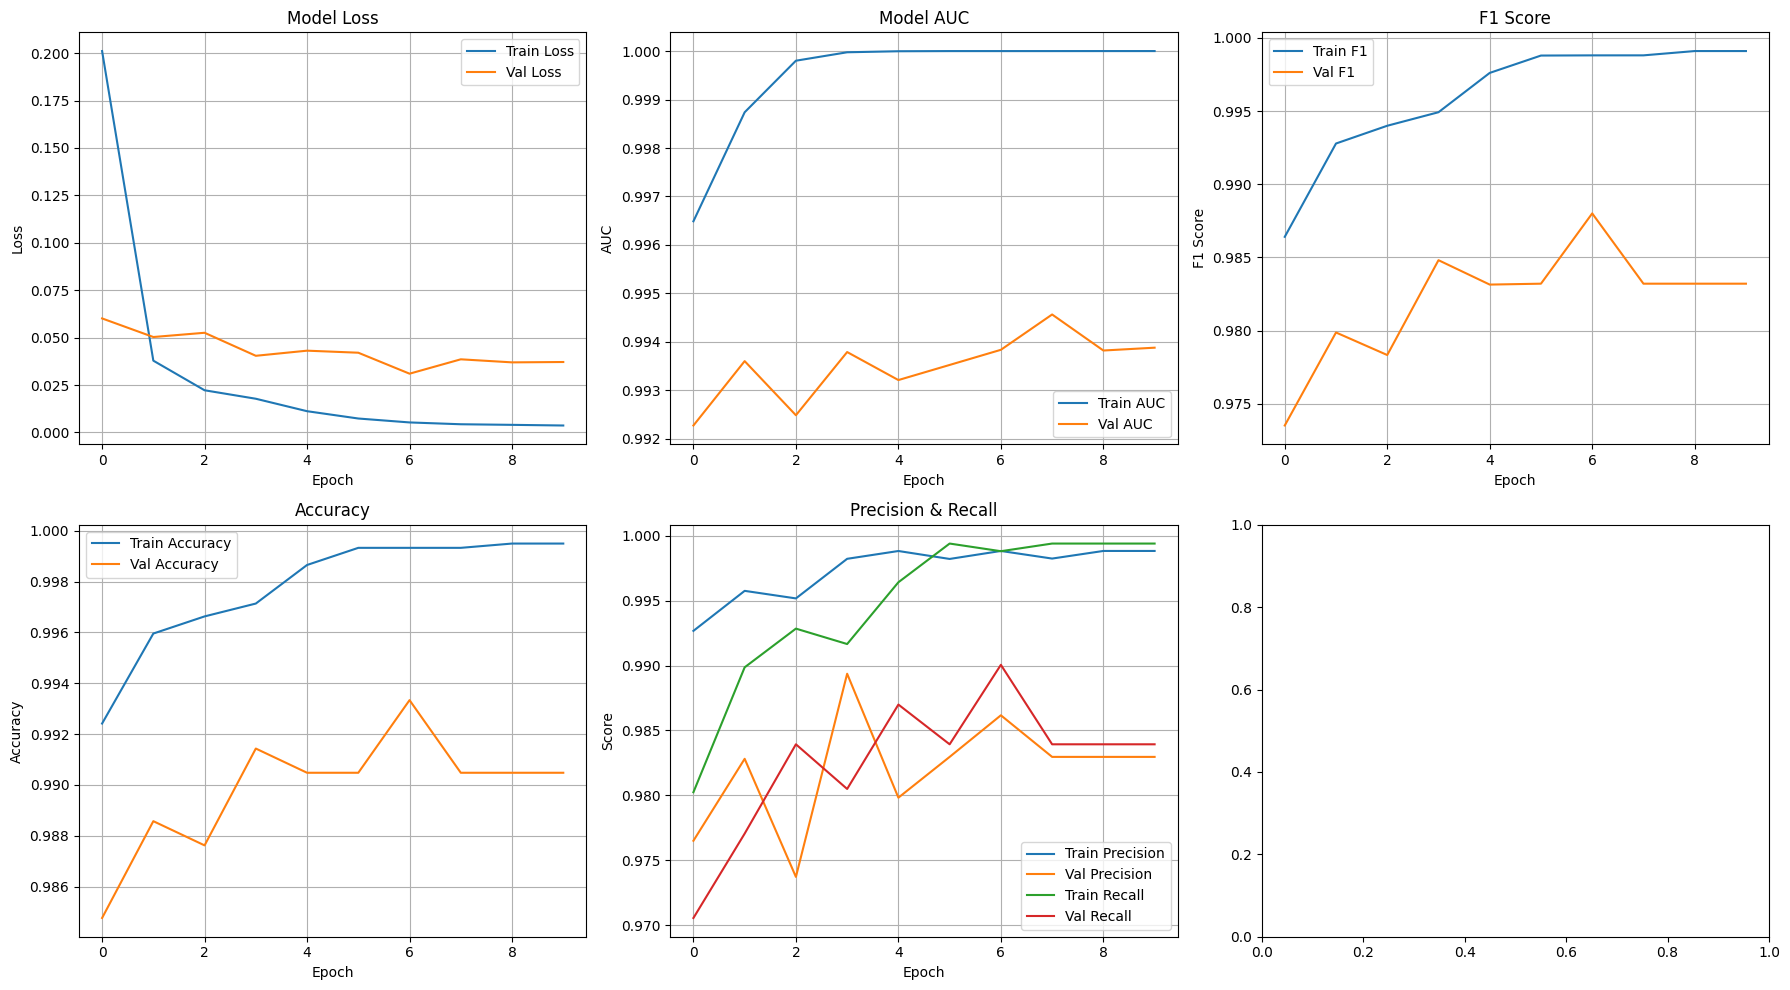

In [66]:
###############################################################################
# ==== PIPELINE PRINCIPAL ====
###############################################################################

if __name__ == "__main__":
    
    print("="*80)
    print("BERT MULTI-LABEL CLASSIFICATION - PyTorch")
    print("="*80)
    
    # 1) Charger les données
    print("\n[1/7] Chargement des données...")
    train_sentences, y_train, val_sentences, y_val = get_data()
    
    # 2) Initialiser le tokenizer
    print("\n[2/7] Initialisation du tokenizer BERT...")
    tokenizer = BertTokenizer.from_pretrained(BERT_PATH)
    tokenizer.save_pretrained("bert_tokenizer_pt")
    
    # 3) Créer les datasets et dataloaders
    print("\n[3/7] Création des datasets...")
    train_dataset = ReviewDataset(train_sentences, y_train, tokenizer, MAX_SEQ_LEN)
    val_dataset = ReviewDataset(val_sentences, y_val, tokenizer, MAX_SEQ_LEN)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    # 4) Créer le modèle
    print("\n[4/7] Création du modèle BERT...")
    model = BertMultiLabelClassifier(n_classes=N_CLASSES)
    model = model.to(device)
    print(f"Nombre de paramètres: {sum(p.numel() for p in model.parameters()):,}")
    
    # 5) Fine-tuning
    print("\n[5/7] Fine-tuning du modèle...")
    history, val_preds, val_true = fine_tune(model, train_loader, val_loader, epochs=10)
    
    # 6) Visualisation de l'entraînement
    print("\n[7/7] Visualisation de l'entraînement...")
    plot_training_history(history)


## Evaluation

In [5]:
# ===============================
# PARAMS
# ===============================
BERT_PATH = "../../models/bert-base-uncased"
TOKENIZER_PATH = "bert_tokenizer_pt"
MODEL_WEIGHTS = "best_weights.pth"
MAX_SEQ_LEN = 128
classes = ["handicap", "pet", "child"]
threshold = 0.95
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ===============================
# 1) Définition du modèle
# ===============================
class BertMultiLabelClassifier(nn.Module):
    def __init__(self, n_classes, dropout=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained(BERT_PATH)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = torch.mean(outputs.last_hidden_state, dim=1)
        x = self.dropout(pooled_output)
        x = self.classifier(x)
        return self.sigmoid(x)


# ===============================
# 2) Charger le modèle + tokenizer
# ===============================
print("Loading tokenizer...")
tokenizer = BertTokenizer.from_pretrained(TOKENIZER_PATH)

print("Loading model...")
model = BertMultiLabelClassifier(n_classes=len(classes))
model.load_state_dict(torch.load(MODEL_WEIGHTS, map_location=device))
model.to(device)
model.eval()


# ===============================
# 3) Charger les données de test
# ===============================
print("Loading test data...")
#df = pd.read_csv("data_test_fixed.csv")
df = pd.read_csv("test.csv")
y_true = df[classes].values.astype(int)


# ===============================
# 4) Fonction d'encodage
# ===============================
def encode_batch(sentences):
    encoded = tokenizer(
        list(sentences),
        padding="max_length",
        truncation=True,
        max_length=MAX_SEQ_LEN,
        return_tensors="pt"
    )
    return encoded["input_ids"], encoded["attention_mask"]


# ===============================
# 5) Prédictions
# ===============================
print("Predicting...")
input_ids, attention_mask = encode_batch(df["review"])

input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)

with torch.no_grad():
    pred = model(input_ids=input_ids, attention_mask=attention_mask).cpu().numpy()

y_pred_bin = (pred > threshold).astype(int)


# ===============================
# 6) Metrics multilabel (par classe)
# ===============================
print("\n=== Metrics multilabel ===\n")

for i, label in enumerate(classes):
    acc = accuracy_score(y_true[:, i], y_pred_bin[:, i])
    prec = precision_score(y_true[:, i], y_pred_bin[:, i], zero_division=0)
    rec = recall_score(y_true[:, i], y_pred_bin[:, i], zero_division=0)
    f1 = f1_score(y_true[:, i], y_pred_bin[:, i], zero_division=0)

    print(f"Label: {label}")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}\n")


# ===============================
# 7) Metrics globales
# ===============================
prec_micro = precision_score(y_true, y_pred_bin, average="micro", zero_division=0)
rec_micro = recall_score(y_true, y_pred_bin, average="micro", zero_division=0)
f1_micro = f1_score(y_true, y_pred_bin, average="micro", zero_division=0)

prec_macro = precision_score(y_true, y_pred_bin, average="macro", zero_division=0)
rec_macro = recall_score(y_true, y_pred_bin, average="macro", zero_division=0)
f1_macro = f1_score(y_true, y_pred_bin, average="macro", zero_division=0)

print("=== Metrics globales ===")
print(f"Micro Precision: {prec_micro:.4f}, Recall: {rec_micro:.4f}, F1: {f1_micro:.4f}")
print(f"Macro Precision: {prec_macro:.4f}, Recall: {rec_macro:.4f}, F1: {f1_macro:.4f}")


Loading tokenizer...
Loading model...
Loading test data...
Predicting...

=== Metrics multilabel ===

Label: handicap
Accuracy : 1.0000
Precision: 0.0000
Recall   : 0.0000
F1-score : 0.0000

Label: pet
Accuracy : 1.0000
Precision: 0.0000
Recall   : 0.0000
F1-score : 0.0000

Label: child
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000

=== Metrics globales ===
Micro Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Macro Precision: 0.3333, Recall: 0.3333, F1: 0.3333
